In [1]:
import os
import time
import collections
import numpy as np
from tempfile import mkdtemp
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

from sklearn.metrics import average_precision_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report,confusion_matrix,average_precision_score

from sknn.mlp import Classifier, Layer
import pickle
import sys
import logging

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Use the maximum number of threads for this script.
from sknn.platform import cpu32, threading

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactore

In [2]:
### READING DATASET ###

# Paths
dataset_path = 'Dataset'
games_dir = next(os.walk(dataset_path))[1]

tag_to_skip = [
    'highlights', 'highlights2', '.DS_Store', '.git', 
    'em_mcs_energy_diff_ascending', 'em_mcs_energy_diff', 'em_mcs_energy']

# Iterating through games
games_data = []
games_path = [os.path.join(dataset_path, g) for g in games_dir]
for path in games_path:
    game_name = os.path.basename(path)
    game_info = os.listdir(path)
    data = collections.OrderedDict()
    for info in game_info:
        tag_name = os.path.splitext(info)[0]
        if tag_name not in tag_to_skip:
            csv_file = os.path.join(path, info)
            if tag_name == 'highlights_boundaries':
                data_value = np.genfromtxt(csv_file, delimiter=',', dtype=None)
            else:
                data_value = np.fromfile(csv_file, sep=' ')
            data[tag_name] = data_value
    data['name'] = game_name
    games_data.append(data)

games_backup = games_data[:]

C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


In [3]:
### CRIANDO VETOR DE GT ###

wanted_cases = ['Gol', 'Perigo']
to_skip = ['name', 'highlights_boundaries']

for game in games_data:
    h = game['highlights_boundaries']
    end = h[-1][0]
    gt = np.zeros(end)
    for line in h:
        tag = line[2].decode('UTF-8').split(' ')
        name = [t for t in tag if t != ''][-1]
        if name in wanted_cases:
            gt[line[0]-1:line[1]] = 1                   
            
    game['gt'] = gt
    del game['highlights_boundaries']

In [4]:
### CORTANDO VALORES EXCEDENTES PARA QUE TODOS OS DADOS TENHAM O MESMO TAMANHO ###

for game in games_data:
    values = [len(v) for k, v in game.items() if k not in ['name']]
    min_l = min(values)
    for k, v in game.items():
        if len(v) > min_l:
            game[k] = v[:min_l]
            

### ZERO PADDING ###
max_length = 0
for game in games_data:
    values = [len(v) for k, v in game.items() if k not in ['name']]
    max_length = max(values) if max(values)>max_length else max_length

for game in games_data:
    for k, v in game.items():
        if k not in ['name']:
            zero_v = np.zeros(max_length)
            if len(v) < max_length:
                zero_v[:len(v)] = v
                game[k] = zero_v

In [5]:
### DIVIDING SPLITS FROM TRAIN, EVAL, TEST ###

games_test = ['chi_swi', 'san_vas']
games_train1 = [g['name'] for g in games_data if g['name'] not in games_test]
games_train2, games_val = train_test_split(games_train1, test_size=0.05)

print('Total train: {}'.format(len(games_train2)))
print('Total test: {}'.format(len(games_test)))
print('Total val: {}'.format(len(games_val)))

Total train: 26
Total test: 2
Total val: 2


In [6]:
def get_frames_ids(gt):
    u, counts = np.unique(gt, return_counts=True)
    ind_0 = [i for i, v in enumerate(gt) if v == 0.0]
    ind_1 = [i for i, v in enumerate(gt) if v == 1.0]
    
    ind_0_ids = np.linspace(0, counts[0]-1, counts[1], dtype=int)
    new_ind_0 = [ind_0[j] for j in ind_0_ids]
    
    return sorted(new_ind_0 + ind_1)

In [7]:
def get_matrix(restriction, skip):
    data = []
    gt = []
    for game in games_data:
        if game['name'] in restriction:
            values_array = np.array(list(game.values()))

            # Getting GT
            gt_game = list(values_array[gt_id])

            # Removing name and GT to train
            values_array = np.delete(values_array, (max(name_id, gt_id)), axis=0)
            values_array = np.delete(values_array, (min(name_id, gt_id)), axis=0)    

            frames_ids = get_frames_ids(gt_game)
            gt += [gt_game[i] for i in frames_ids]

            game_features = []
            for feature in values_array:
                # Normalizing
                norm_feature = np.squeeze(normalize([feature], axis=1))

                M_feature = np.repeat([norm_feature], f_size, axis=0)
                for i, v in enumerate(skip_values):
                    M_feature[i] = np.roll(M_feature[i], v, axis=0)

                M_feature = M_feature[:, frames_ids]

                M_feature = np.transpose(M_feature)
                if len(game_features) == 0:
                    game_features = M_feature
                else:
                    game_features = np.concatenate((game_features, M_feature), axis=1)

            if len(data) == 0:
                data = game_features
            else:
                data = np.concatenate((data, game_features), axis=0)


    gt = np.array(gt)
    
    return data, gt


In [8]:
for i, tag_name in enumerate(games_data[10].keys()):
    if tag_name == 'name':
        name_id = i
    if tag_name == 'gt':
        gt_id = i

skip = 8
f_size = 61
skip_values = np.arange(-30*skip, 31*skip, skip)

X_train, y_train = get_matrix(games_train2, skip)

X_test, y_test = get_matrix(games_test, skip)

X_val, y_val = get_matrix(games_val, skip)


print('Train', X_train.shape, y_train.shape)
print('Val', X_val.shape, y_val.shape)
print('Test', X_test.shape, y_test.shape)

Train (149716, 976) (149716,)
Val (12756, 976) (12756,)
Test (9284, 976) (9284,)


In [9]:

logging.basicConfig(
            format="%(message)s",
            level=logging.DEBUG,
            stream=sys.stdout)

nn = Classifier(
    layers=[
        Layer("Tanh", units=10),
        Layer("Tanh", units=10),
        Layer("Softmax")],
    learning_rate=0.01,
    n_iter=25,
    verbose=True,
    valid_set=(X_val, y_val))

nn.fit(X_train, y_train)

pickle.dump(nn, open('nn.pkl', 'wb'))


Initializing neural network with 3 layers, 976 inputs and 2 outputs.
  - Dense: Tanh       Units:  10  
  - Dense: Tanh       Units:  10  
  - Dense: Softmax    Units:  2   

Training on dataset of 134,136 samples with 131,185,008 total size.
  - Train: 134,136    Valid: 10,994
  - Terminating loop after 25 total iterations.
  - Early termination after 10 stable iterations.

Epoch       Training Error       Validation Error       Time
------------------------------------------------------------
    1         ..............................................                                                            5.408e-01             4.038e-01        451.4s
    2         ..............................................                                                            3.230e-01             3.627e-01        400.5s
    3         ..............................................                                                            2.891e-01             3.373e-01        430.4s
  

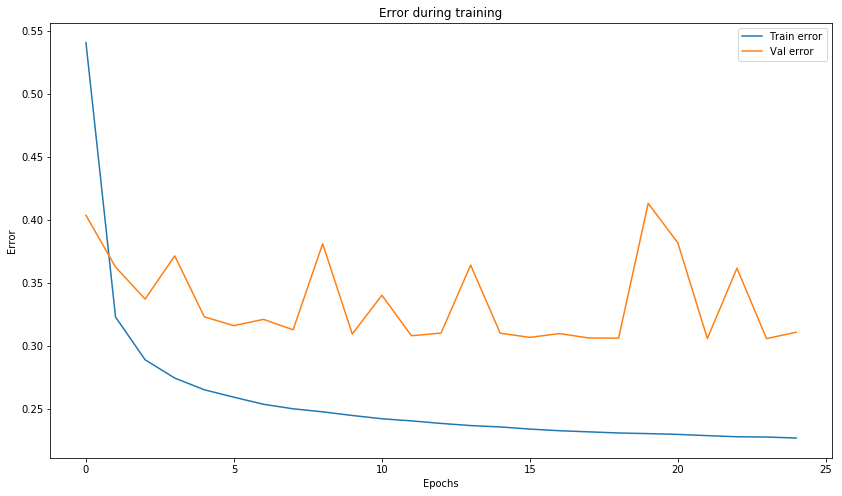

In [36]:
# train_error = [5.408e-01, 3.230e-01, 2.891e-01, 2.746e-01, 2.653e-01, 2.594e-01, 2.538e-01, 2.502e-01, 2.478e-01, 2.449e-01, 2.423e-01, 2.406e-01, 2.386e-01, 2.369e-01, 2.358e-01, 2.341e-01, 2.328e-01, 2.319e-01, 2.310e-01, 2.305e-01, 2.299e-01, 2.289e-01, 2.280e-01, 2.278e-01, 2.270e-01]
# val_error = [4.038e-01, 3.627e-01, 3.373e-01, 3.716e-01,3.232e-01, 3.162e-01,3.212e-01, 3.129e-01, 3.812e-01, 3.096e-01, 3.403e-01, 3.082e-01, 3.103e-01, 3.643e-01,3.102e-01, 3.069e-01, 3.099e-01, 3.064e-01, 3.063e-01, 4.133e-01, 3.820e-01, 3.060e-01, 3.618e-01, 3.059e-01, 3.110e-01]

file_path = 'nn_2.txt'

train_error = []
val_error = []

with open(file_path, 'r') as file:
    for line in file:
        chk = line.replace('\n', '').split(' ')
        chk = [c for c in chk if (c != '' and '...' not in c)]
        train_error.append(float(chk[1]))
        val_error.append(float(chk[2]))
        
assert(len(train_error) == len(val_error))
        
dots = np.arange(len(train_error))

plt.figure(figsize=(14,8))
plt.plot(dots, train_error, label='Train error')
plt.plot(dots, val_error, label='Val error')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error during training')
plt.show()

[(26626, 2)]
[(26626, 2)]
Average precision-recall score: 0.88
Precision: [0.94596736 0.90195658]
Recall: [0.89686772 0.94877188]
[[11940  1373]
 [  682 12631]]


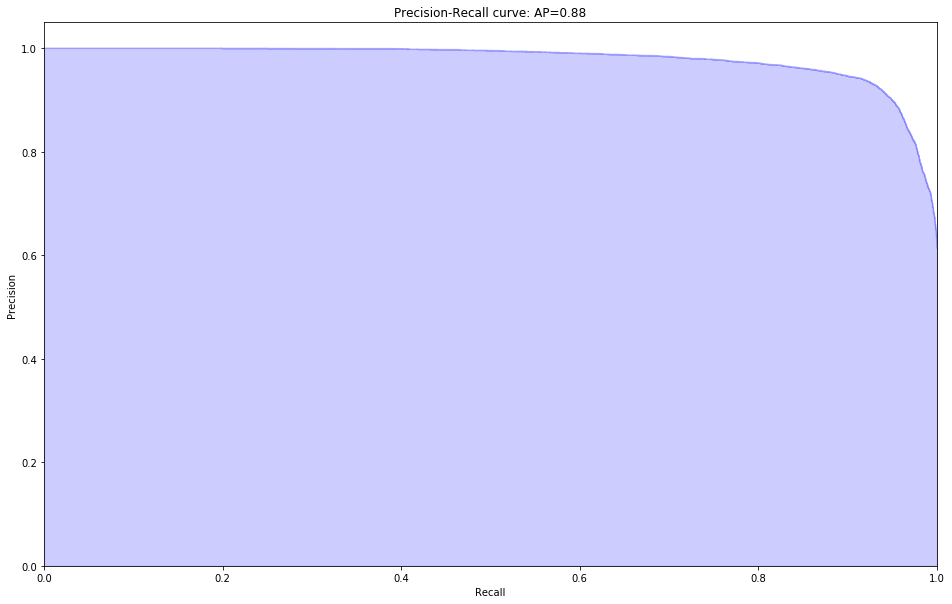

In [11]:
# Getting predictions
y_predictions = nn.predict_proba(X_test)
y_score = nn.predict(X_test)

# Calculating average precision
average_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

# Getting precision and recall
p_r_fs = precision_recall_fscore_support(y_test, y_score)
print('Precision: {}'.format(p_r_fs[0]))
print('Recall: {}'.format(p_r_fs[1]))

print(confusion_matrix(y_test,y_score))

# Plotting PR curve
precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])
average_precision = average_precision_score(y_test, y_score)

plt.figure(figsize=(16,10))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={:.2f}'.format(average_precision))
plt.show()

In [ ]:

logging.basicConfig(
            format="%(message)s",
            level=logging.DEBUG,
            stream=sys.stdout)

nn = Classifier(
    layers=[
        Layer("Tanh", units=10),
        Layer("Tanh", units=10),
        Layer("Softmax")],
    learning_rate=0.001,
    n_iter=25,
    verbose=True,
    valid_set=(X_val, y_val))

nn.fit(X_train, y_train)

pickle.dump(nn, open('nn_simple.pkl', 'wb'))


Initializing neural network with 3 layers, 976 inputs and 2 outputs.
  - Dense: Tanh       Units:  10  
  - Dense: Tanh       Units:  10  
  - Dense: Softmax    Units:  2   

Training on dataset of 149,716 samples with 146,422,248 total size.
  - Train: 149,716    Valid: 12,756
  - Terminating loop after 25 total iterations.
  - Early termination after 10 stable iterations.

Epoch       Training Error       Validation Error       Time
------------------------------------------------------------
    1         ..............................................                                                            5.187e-01             3.295e-01        305.0s
    2         ..............................................                                                            3.128e-01             2.952e-01        303.6s
    3         ..............................................                                                            2.815e-01             2.834e-01        284.3s
  

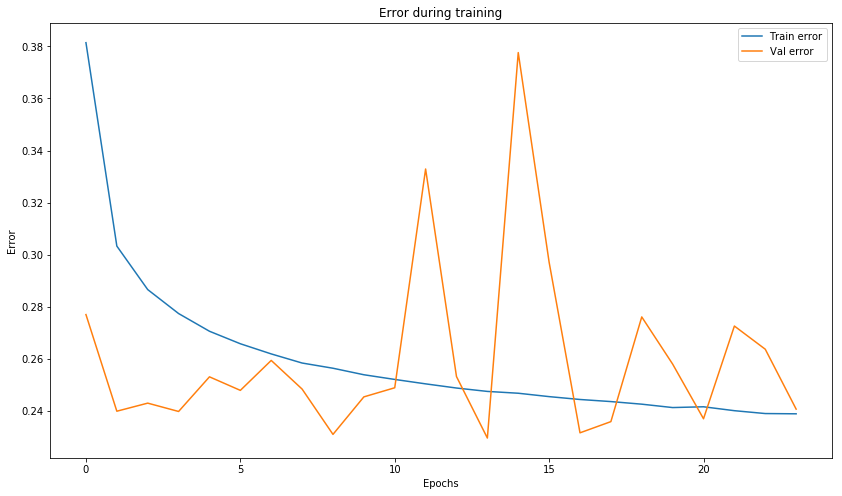

In [37]:
file_path = 'nn_simple.txt'

train_error = []
val_error = []

with open(file_path, 'r') as file:
    for line in file:
        chk = line.replace('\n', '').split(' ')
        chk = [c for c in chk if (c != '' and '...' not in c)]
        train_error.append(float(chk[1]))
        val_error.append(float(chk[2]))
        
assert(len(train_error) == len(val_error))
        
dots = np.arange(len(train_error))

plt.figure(figsize=(14,8))
plt.plot(dots, train_error, label='Train error')
plt.plot(dots, val_error, label='Val error')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error during training')
plt.show()

[(9284, 2)]
[(9284, 2)]
Average precision-recall score: 0.86
Precision: [0.87320476 0.91247166]
Recall: [0.91684619 0.86686773]
[[4256  386]
 [ 618 4024]]


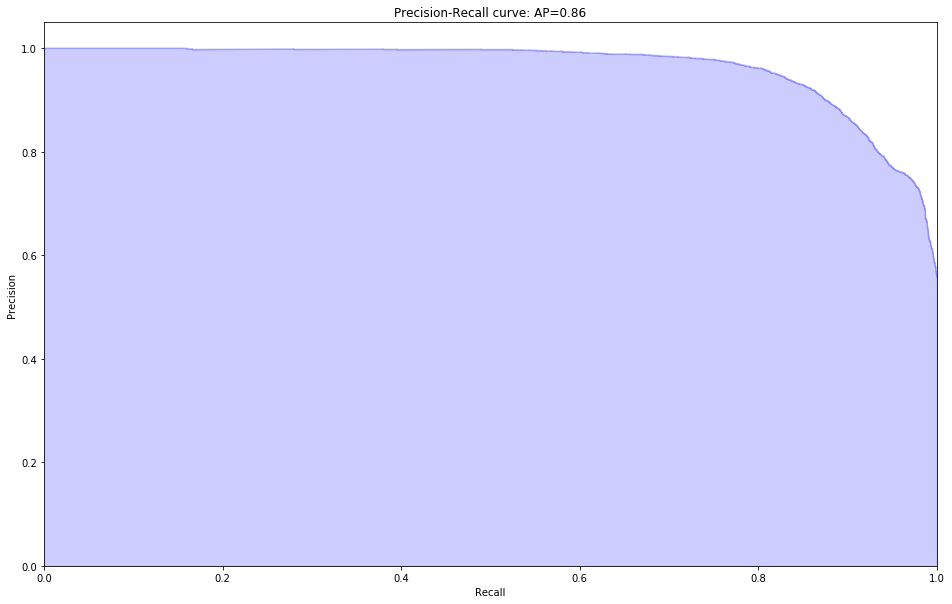

In [10]:
# Getting predictions
y_predictions = nn.predict_proba(X_test)
y_score = nn.predict(X_test)

# Calculating average precision
average_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

# Getting precision and recall
p_r_fs = precision_recall_fscore_support(y_test, y_score)
print('Precision: {}'.format(p_r_fs[0]))
print('Recall: {}'.format(p_r_fs[1]))

print(confusion_matrix(y_test,y_score))

# Plotting PR curve
precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])
average_precision = average_precision_score(y_test, y_score)

plt.figure(figsize=(16,10))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={:.2f}'.format(average_precision))
plt.show()

In [11]:

logging.basicConfig(
            format="%(message)s",
            level=logging.DEBUG,
            stream=sys.stdout)

nn1 = Classifier(
    layers=[
        Layer("Tanh", units=10),
        Layer("Linear", units=10),
        Layer("Softmax")],
    learning_rate=0.01,
    n_iter=25,
    verbose=True,
    valid_set=(X_val, y_val))

nn1.fit(X_train, y_train)

pickle.dump(nn, open('nn1.pkl', 'wb'))


Initializing neural network with 3 layers, 976 inputs and 2 outputs.
  - Dense: Tanh       Units:  10  
  - Dense: Linear     Units:  10  
  - Dense: Softmax    Units:  2   

Training on dataset of 149,716 samples with 146,422,248 total size.
  - Train: 149,716    Valid: 12,756
  - Terminating loop after 25 total iterations.
  - Early termination after 10 stable iterations.

Epoch       Training Error       Validation Error       Time
------------------------------------------------------------
    1         ..............................................                                                            3.690e-01             2.911e-01        242.1s
    2         ..............................................                                                            2.885e-01             2.590e-01        253.7s
    3         ..............................................                                                            2.712e-01             2.485e-01        236.6s
  

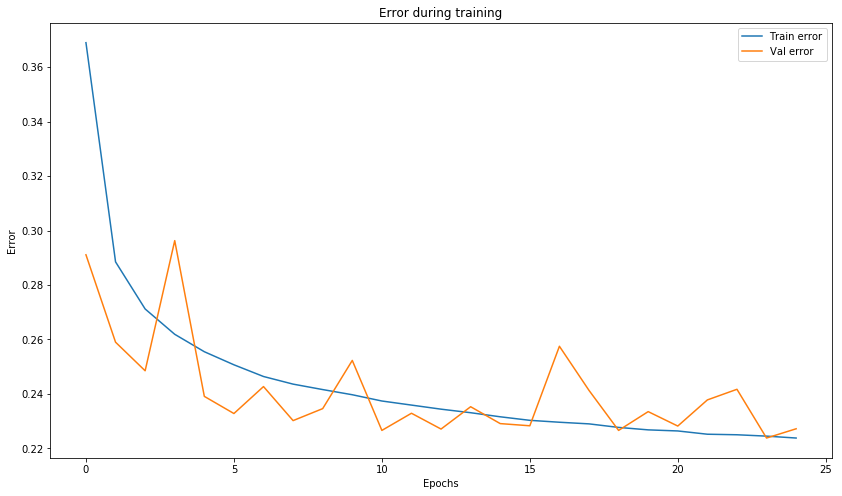

In [39]:
file_path = 'nn_tanhlinear.txt'

train_error = []
val_error = []

with open(file_path, 'r') as file:
    for line in file:
        chk = line.replace('\n', '').split(' ')
        chk = [c for c in chk if (c != '' and '...' not in c)]
        train_error.append(float(chk[1]))
        val_error.append(float(chk[2]))
        
assert(len(train_error) == len(val_error))
        
dots = np.arange(len(train_error))

plt.figure(figsize=(14,8))
plt.plot(dots, train_error, label='Train error')
plt.plot(dots, val_error, label='Val error')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error during training')
plt.show()

[(9284, 2)]
[(9284, 2)]
Average precision-recall score: 0.85
Precision: [0.88022814 0.8956044 ]
Recall: [0.89767342 0.87785437]
[[4167  475]
 [ 567 4075]]


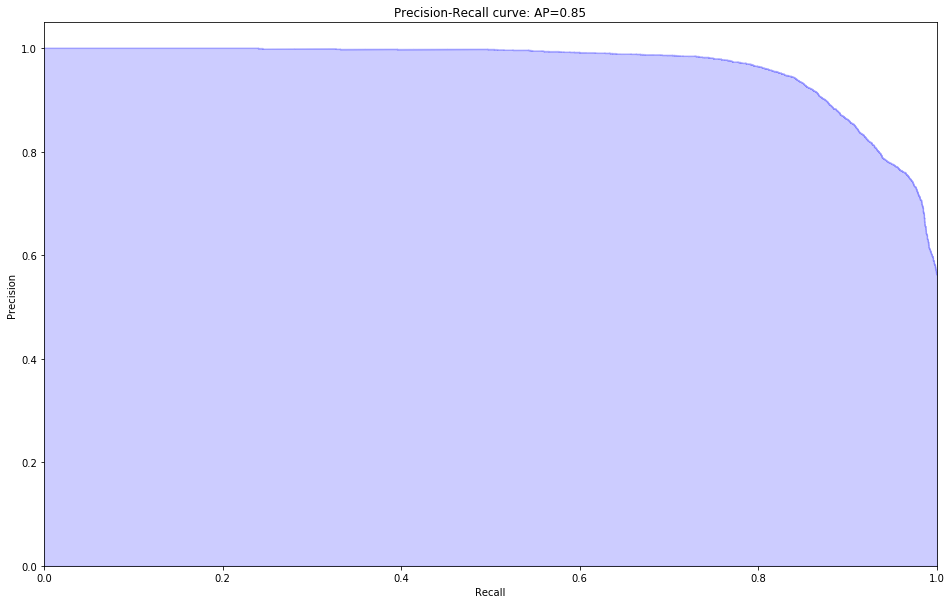

In [12]:
# Getting predictions
y_predictions = nn1.predict_proba(X_test)
y_score = nn1.predict(X_test)

# Calculating average precision
average_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

# Getting precision and recall
p_r_fs = precision_recall_fscore_support(y_test, y_score)
print('Precision: {}'.format(p_r_fs[0]))
print('Recall: {}'.format(p_r_fs[1]))

print(confusion_matrix(y_test,y_score))

# Plotting PR curve
precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])
average_precision = average_precision_score(y_test, y_score)

plt.figure(figsize=(16,10))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={:.2f}'.format(average_precision))
plt.show()